In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
from tqdm.notebook import trange, tqdm

# Нахождение распределение статистики с помощью бутстрепа

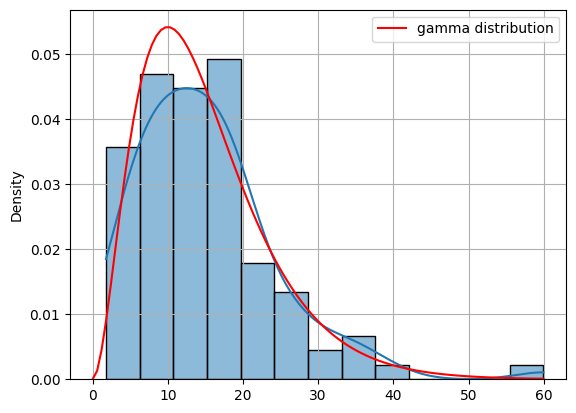

In [2]:
N = 100
a = 3
scale = 5
distribution = stats.gamma(a=a, scale=scale)
x = distribution.rvs(size=N, random_state=23)
xa = np.linspace(0, max(x), 100)
pdf = distribution.pdf(xa)

sns.histplot(data=x, kde=True, stat='density')
plt.plot(xa, pdf, label='gamma distribution', c='r')
plt.legend()
plt.grid()

# Сравнение эмпирической функции с истинной

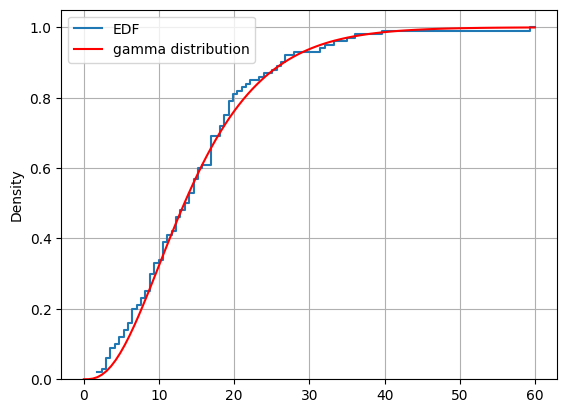

In [3]:
cdf = distribution.cdf(xa)

sns.histplot(
    data=x, cumulative=True, stat='density', 
    fill=False, element='step', bins=100, label = 'EDF'
)

plt.plot(xa, cdf, label='gamma distribution', c='r')
plt.legend()
plt.grid()

# Распределение доверительного интервала

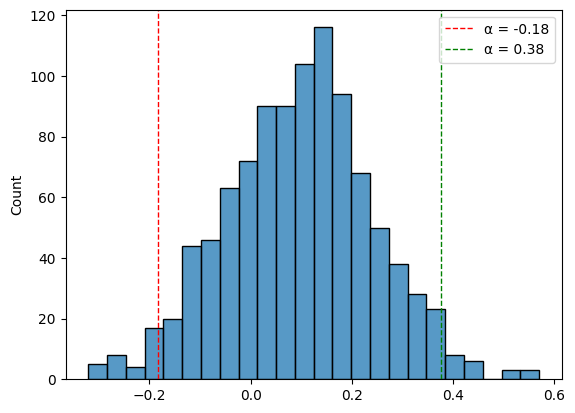

In [4]:
results = []
for i in range(1000):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0.1, 1, 100)
    diff = np.mean(b) - np.mean(a)
    results.append(diff)

left = np.quantile(results, 0.025)
right = np.quantile(results, 0.975)
ax = sns.histplot(results)
ax.axvline(left, color='red', linestyle='--', linewidth=1, label=f'α = {left:.2f}')
ax.axvline(right, color='green', linestyle='--', linewidth=1, label=f'α = {right:.2f}')
ax.legend()

# Мощность и минимальный размер выборки

In [5]:
def bootstrap_test(control, treatment, n_boot=1000, alpha = 0.05, statistic=np.mean):
    boot_control = np.random.choice(control, size=(n_boot, len(control)), replace=True)
    boot_treatment = np.random.choice(treatment, size=(n_boot, len(control)), replace=True)
    boot_diffs = statistic(boot_treatment, axis = 1) - statistic(boot_control, axis = 1)

    ci_low = np.percentile(boot_diffs, 100 * alpha / 2)
    ci_high = np.percentile(boot_diffs, 100 * (1 - alpha / 2))

    return 1 if (ci_low > 0 or ci_high < 0) else 0

In [6]:
from joblib import Parallel, delayed

def run_simulation(historical_data, n, effect_func, n_boot):
    control = np.random.choice(historical_data, size=n, replace=True)
    treatment = effect_func(np.random.choice(historical_data, size=n, replace=True))
    return bootstrap_test(control, treatment)

def get_power(historical_data, n, effect_func, n_simulations=1000, n_boot=1000, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_simulation)(historical_data, n, effect_func, n_boot)
        for _ in range(n_simulations)
    )
    return sum(results) / n_simulations

def estimate_sample_size(historical_data, effect_func, alpha=0.05, power=0.8,
                          n_simulations_coarse=200, n_simulations_fine=3000, n_boot=1000, n_max=5000, n_jobs=-1):

    max_power = get_power(historical_data, n_max, effect_func, n_simulations_fine, n_boot, n_jobs)
    if max_power < power:
        raise ValueError(
            f"Невозможно достичь мощности {power} при n_max={n_max}. \n"
            f"Достигнутая мощность: {max_power:.2f}. \n"
            f"Увеличьте n_max или пересмотрите ожидаемый эффект."
        )
    low, high = 50, n_max
    i = 0
    while high - low > 1000:
        i += 1
        mid = (low + high) // 2
        power_t = get_power(historical_data, mid, effect_func, n_simulations_coarse, n_boot, n_jobs)
        if power_t >= power:
            high = mid
        else:
            low = mid
        
        print('coarse', i, power_t, mid, high)

    i = 0
    while high - low > 100:
        i += 1
        mid = (low + high) // 2
        power_t = get_power(historical_data, mid, effect_func, n_simulations_fine, n_boot, n_jobs)
        if power_t >= power:
            high = mid
        else:
            low = mid
        
        print('fine', i, power_t, mid, high)

    return high

In [12]:
%%time
effect = 1.1

try:
    sample_size = estimate_sample_size(historical_data=x, effect_func = lambda x: x * effect)
except ValueError as e:
    print(e)

coarse 1 1.0 2525 2525
coarse 2 0.975 1287 1287
coarse 3 0.795 668 1287
fine 1 0.9303333333333333 977 977
fine 2 0.8773333333333333 822 822
fine 3 0.8406666666666667 745 745
CPU times: total: 11.6 s
Wall time: 46 s


In [13]:
rejections = 0
for _ in trange(1000):
    rejections += run_simulation(x, sample_size, lambda x: x * effect, 1000)

rejections/1000

  0%|          | 0/1000 [00:00<?, ?it/s]

0.828

In [14]:
powers = []
for n_sim in trange(100):
    powers.append(get_power(x, sample_size, lambda x: x*effect, 1000))

In [15]:
np.quantile(powers, [0.025, 0.975])

array([0.82095, 0.868  ])